# CZ1016 : Assignment

---

### Essential Libraries

Let us begin by importing the essential Python Libraries.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

---

### Setup : Import the Dataset

Dataset : **"smsdata.txt"** (use `read_table` function from Pandas to import)     
After importing, take a quick look at the dataset using the `head` function.

In [ ]:
# Read the dataset as per the format
# response label <tab> sms as string
smsData = pd.read_table('smsdata.txt', sep = "\t", header = None)
smsData.head()

,0,1
0,good,"Go until jurong point, crazy.. Available only ..."
1,good,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Fix the headers / column labels
smsData.columns = ["label", "text"]
smsData.head()

,label,text
0,good,"Go until jurong point, crazy.. Available only ..."
1,good,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Basic information about the data
smsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label    5572 non-null object
text     5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
smsData.groupby("label").describe()

text                                                               
      count unique                                                top freq
label                                                                     
good   4825   4516                             Sorry, I'll call later   30
spam    747    642  Please call our customer service representativ...    4

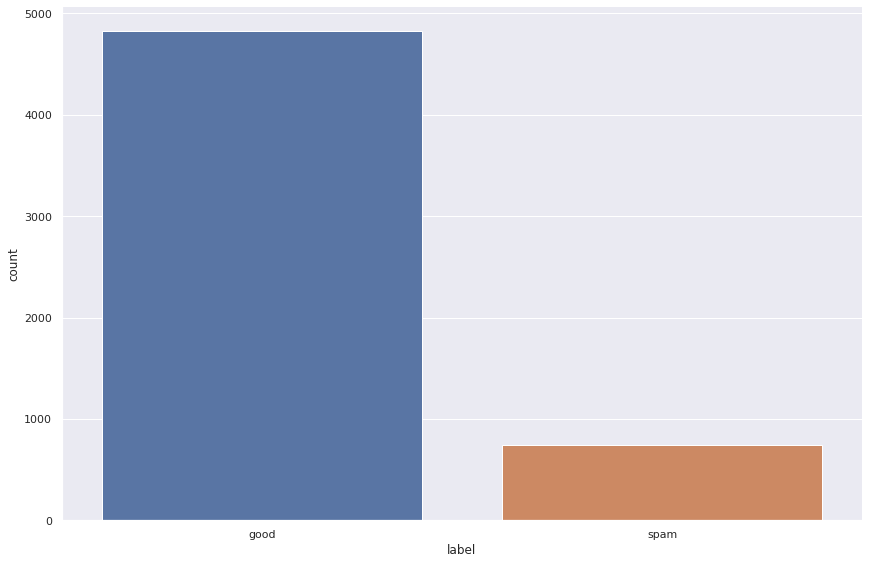

In [ ]:
sb.catplot(x = "label", data = smsData, kind = "count", height = 8, aspect = 1.5)

###Seems like the data is quite unbalanced. Good messages are much more frequent than spam messages. This might give us a relatively high false negative rate (as in more spam messages will be flagged as good messages)

---

## Solution : Classification

Use the labeled (`good`/`spam`) text messages in `smsData` to build a tree-based binary classifier that is capable of distinguishing `spam` text messages from the `good` ones. You may build a single decision tree or an ensemble (forest), whichever is better in this case. Try both, and find out which one is better.        

In [ ]:
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import nltk
nltk.download("stopwords")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#First, we need to determine the features that would be useful in our classification
We can guess a few features that might be helpful in our classification:

1. The length of the message might be related to whether it's a spam or a good message
2. There may be certain words that appear more often in spam messages than good messages and vice versa
3. Messages that contain website links or phone numbers are more likely to be a spam message
4. Large amount of special characters like $ or ! might indicate a spam message

#1. The length of the message

In [ ]:
smsData["Length"] = smsData["text"].apply(len)
smsData

,label,text,Length
0,good,"Go until jurong point, crazy.. Available only ...",111
1,good,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,good,U dun say so early hor... U c already then say...,49
4,good,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160
5568,good,Will ü b going to esplanade fr home?,36
5569,good,"Pity, * was in mood for that. So...any other s...",57
5570,good,The guy did some bitching but I acted like i'd...,125


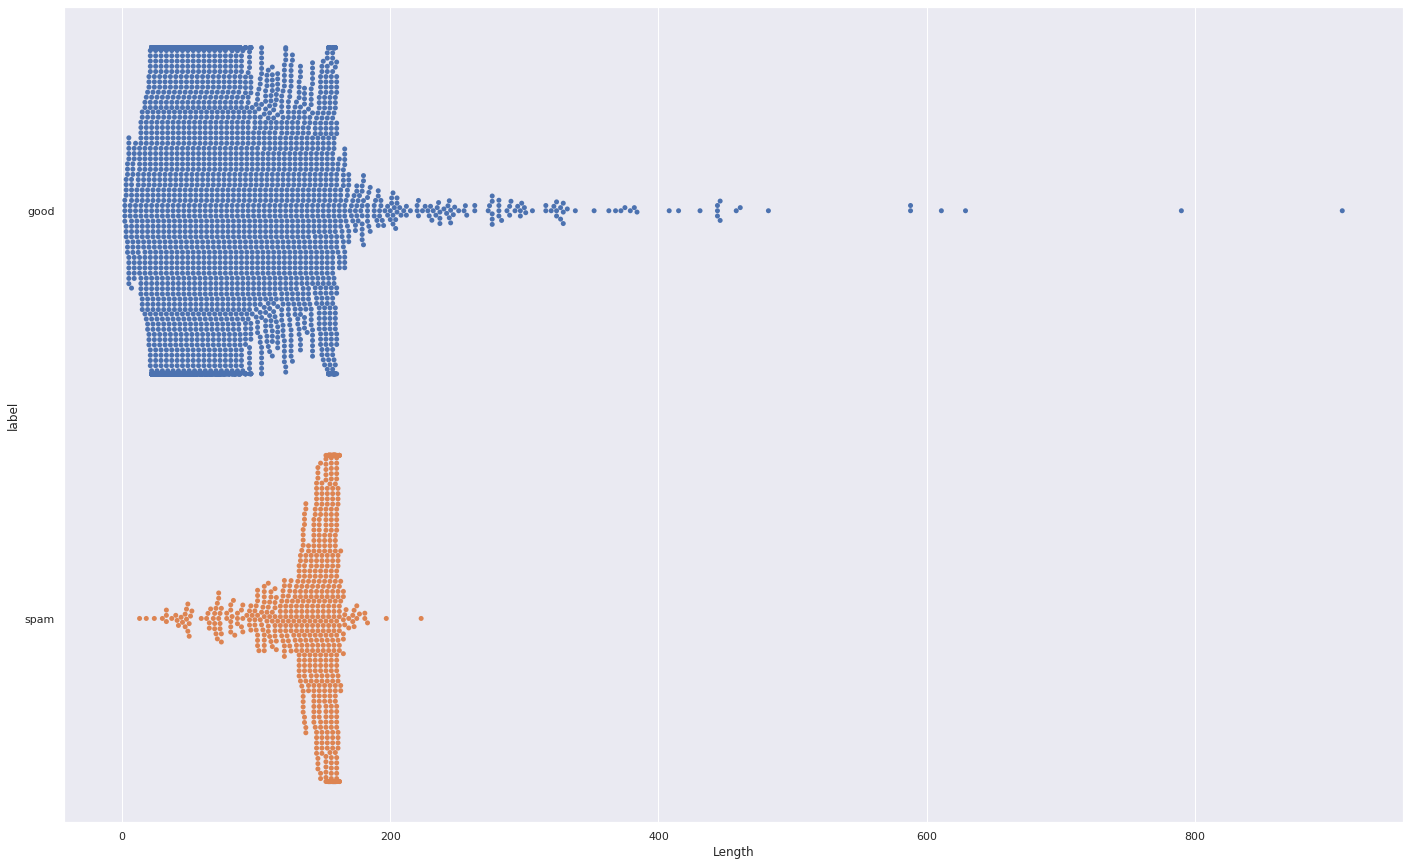

In [ ]:
f, axes = plt.subplots(1, 1, figsize = (24, 15))
sb.swarmplot(x = "Length", y = "label", data = smsData, orient = "h")

###*Seems like it would be a good indicator*

#2. If there are any phone numbers or website links
We will have a way to detect the common website link patterns later (like whether the string has a "https", ".com" or ".net") in later steps.
Let's look for phone numbers first

In [ ]:
#Since we don't know how many numbers there are in a normal phone number yet (some spam messages have a 4-digit number while some have a 11-digit number), let's look for all instances of numbers

NumRegX = re.compile(r'\d+')
#This will look for any instance of numbers in a message
def NumLen(text):
  num = NumRegX.findall(text)
  #This will return all instances of consecutive digits
  if len(num) == 0:
    return 0
  numlen = len(str(num[0]))
  for i in num:
    if numlen <= len(str(i)):
      numlen = len(str(i))
  return numlen
  #This will return the longest number in that message

In [ ]:
smsData["Longest number"] = smsData["text"].apply(NumLen)
smsData.head()

,label,text,Length,Longest number
0,good,"Go until jurong point, crazy.. Available only ...",111,0
1,good,Ok lar... Joking wif u oni...,29,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,11
3,good,U dun say so early hor... U c already then say...,49,0
4,good,"Nah I don't think he goes to usf, he lives aro...",61,0


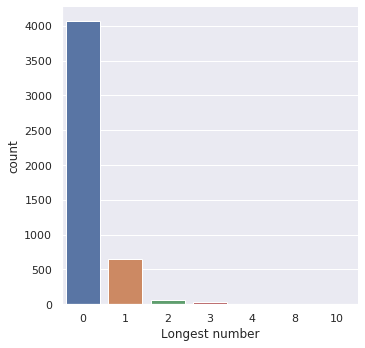

In [ ]:
sb.catplot(x = "Longest number", data = smsData[smsData["label"] == "good"], kind = "count")

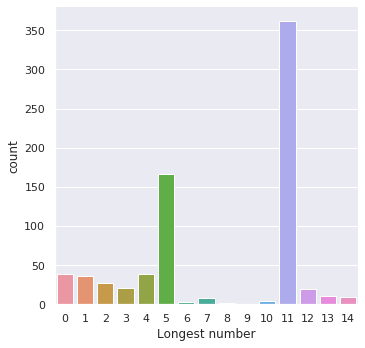

In [ ]:
sb.catplot(x = "Longest number", data = smsData[smsData["label"] == "spam"], kind = "count")

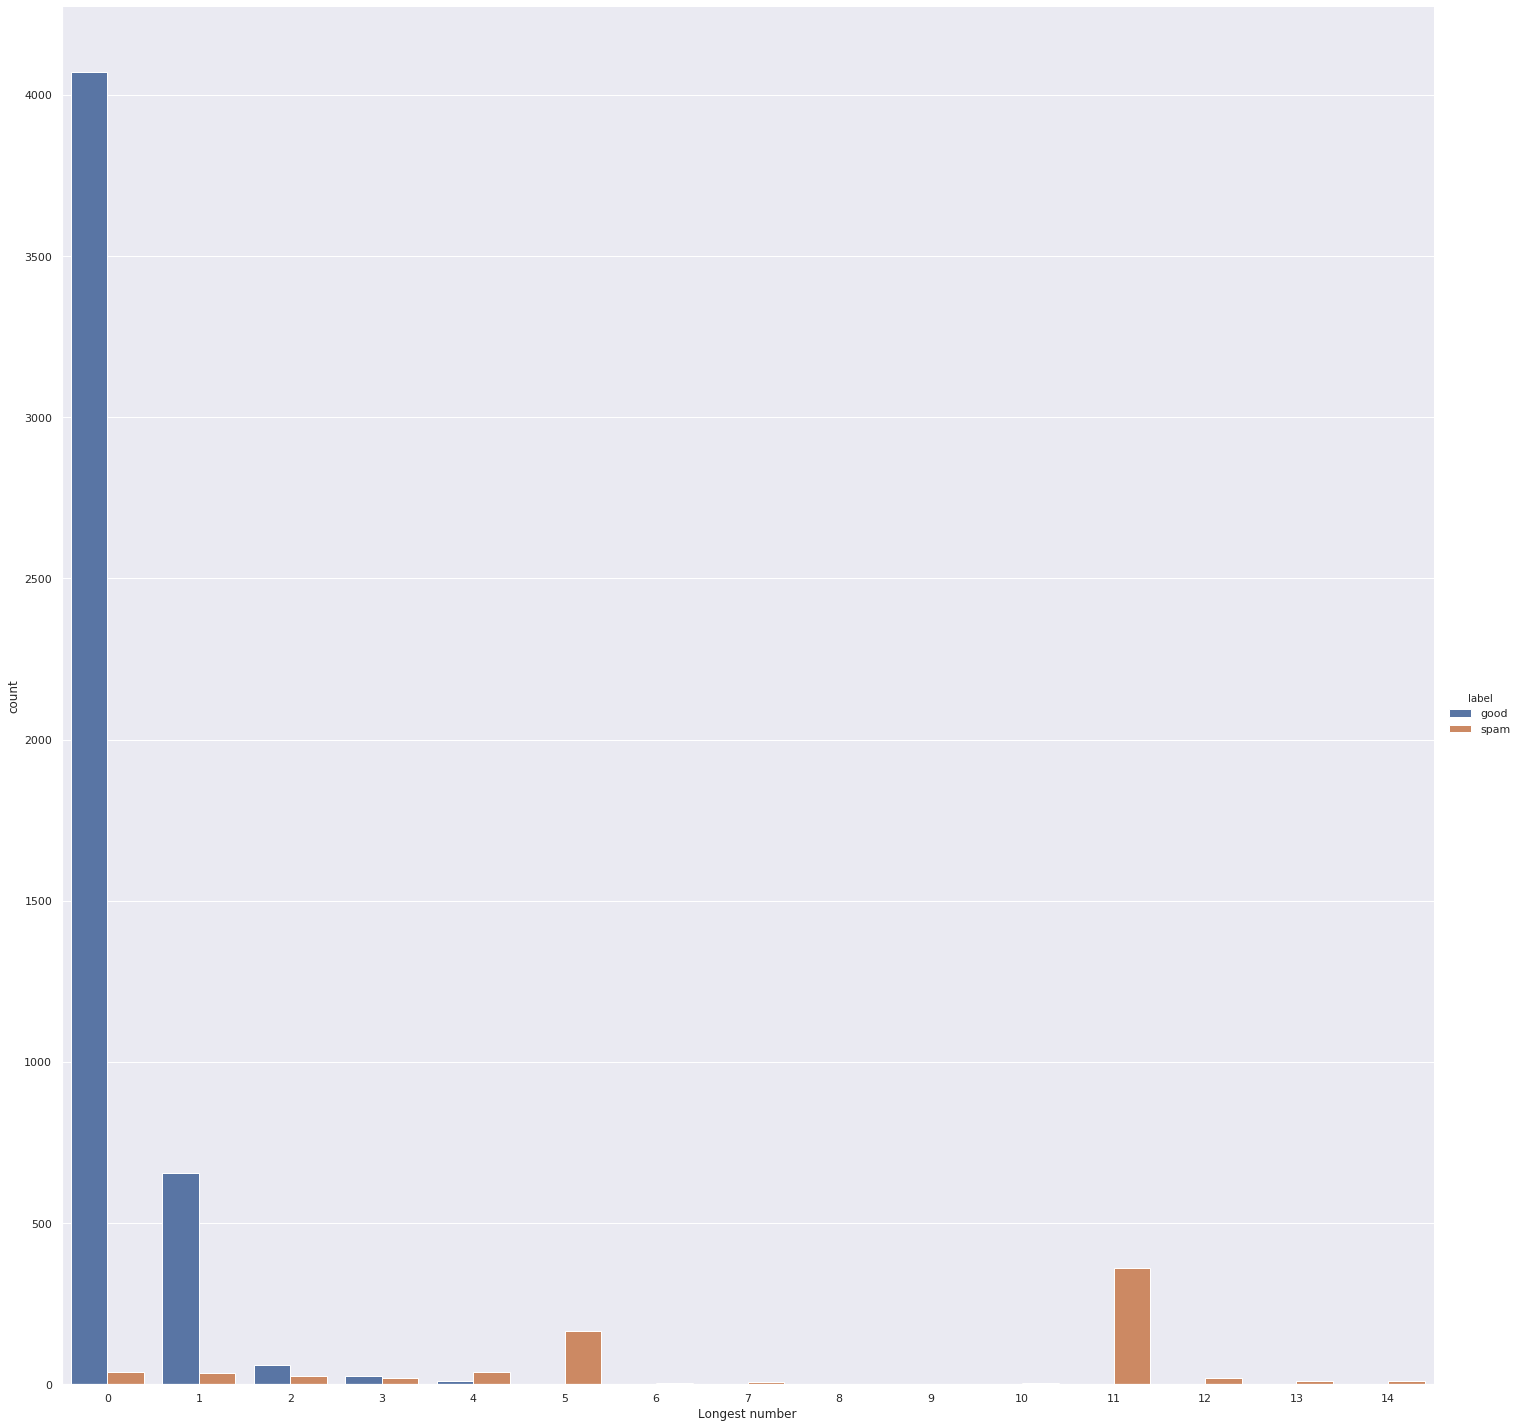

In [ ]:
sb.catplot(x = "Longest number", hue = "label", data = smsData, kind = "count", height = 20)

###*This would be useful in our classification*
Seems like there are a lot of good messages with no numbers in it, and messages with 5-digit and 11-digit numbers are only in spam messages


#If there are certain words in the text
Obviously, some words are much more present in a good message than a spam message, and vice versa.

Let's find out which words would be useful

##Clean up the data
We will need to do 2 tasks:

1. Remove all punctuations (like periods and commas) from the text, to leave only the words left
2. Stopwords - words that provides little context (like "and" and "has") - should be removed as well. We will use NLTK's stopword corpus **[1]**

In [ ]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
text_clean = smsData['text'].copy()
def text_process(text):
    
    words_raw = text.translate(str.maketrans(string.punctuation, '                                '))
    #Replaces all punctuations with a whitespace character 
    words_list = [word for word in words_raw.split() if (word.lower() not in stopwords.words('english') and word != '')]
    #Removes all stopwords
    return ' '.join(words_list)

text_clean = text_clean.apply(text_process)
text_clean.head(30)

0     Go jurong point crazy Available bugis n great ...
1                               Ok lar Joking wif u oni
2     Free entry 2 wkly comp win FA Cup final tkts 2...
3                   U dun say early hor U c already say
4                Nah think goes usf lives around though
5     FreeMsg Hey darling 3 week word back like fun ...
6        Even brother like speak treat like aids patent
7     per request Melle Melle Oru Minnaminunginte Nu...
8     WINNER valued network customer selected receiv...
9     mobile 11 months U R entitled Update latest co...
10    gonna home soon want talk stuff anymore tonigh...
11    SIX chances win CASH 100 20 000 pounds txt CSH...
12    URGENT 1 week FREE membership £100 000 Prize J...
13    searching right words thank breather promise w...
14                                          DATE SUNDAY
15    XXXMobileMovieClub use credit click WAP link n...
16                                        Oh k watching
17    Eh u remember 2 spell name Yes v naughty m

##Extract the features
###To extract features in the text, we will use scikit-learn's vectorizers: Count Vectorizer and TF-IDF Vectorizer **[2]**.



###First let's use the most simple vectorizer, Count Vectorizer. This will return the count of a word in a text message, in the form of a matrix

In [ ]:
C_vectorizer = CountVectorizer(min_df = 5)
#min_df will set the minimum document frequency to 5
#Words that appear too little in the corpus shouldn't be used in our classification, as it is very unlikely that we will encounter the same word again. Leaving them in would cause overfitting
C_features = C_vectorizer.fit_transform(text_clean)
C_features

<5572x1695 sparse matrix of type '<class 'numpy.int64'>'
	with 36767 stored elements in Compressed Sparse Row format>

Seems like the vectorizer found 1695 different words in the corpus, let's take a look

In [ ]:
C_vectorizer.get_feature_names()

['00',
 '000',
 '02',
 '03',
 '04',
 '06',
 '0800',
 '08000839402',
 '08000930705',
 '0870',
 '08707509020',
 '08712300220',
 '08712460324',
 '08718720201',
 '09050090044',
 '10',
 '100',
 '1000',
 '10am',
 '10p',
 '11',
 '11mths',
 '12',
 '12hrs',
 '1327',
 '150',
 '150p',
 '150pm',
 '150ppm',
 '16',
 '18',
 '1st',
 '1x150p',
 '20',
 '200',
 '2000',
 '2003',
 '2004',
 '20p',
 '21',
 '25',
 '250',
 '25p',
 '28',
 '2day',
 '2lands',
 '2mrw',
 '2nd',
 '2nite',
 '2optout',
 '30',
 '300',
 '3030',
 '350',
 '3510i',
 '36504',
 '3g',
 '3rd',
 '400',
 '40gb',
 '4th',
 '4u',
 '50',
 '500',
 '5000',
 '50p',
 '530',
 '5wb',
 '5we',
 '60p',
 '62468',
 '750',
 '7pm',
 '800',
 '80062',
 '8007',
 '82277',
 '83355',
 '85023',
 '86021',
 '86688',
 '87066',
 '87077',
 '8th',
 '900',
 '9am',
 'aathi',
 'abiola',
 'able',
 'abt',
 'ac',
 'acc',
 'accept',
 'access',
 'account',
 'across',
 'activate',
 'actually',
 'ad',
 'add',
 'added',
 'address',
 'admirer',
 'adult',
 'advance',
 'advice',
 'aft',
 

In [ ]:
count_mat = pd.DataFrame(C_features.toarray(), columns= C_vectorizer.get_feature_names())
count_mat.describe()

,00,000,02,03,04,06,0800,08000839402,08000930705,0870,08707509020,08712300220,08712460324,08718720201,09050090044,10,100,1000,10am,10p,11,11mths,12,12hrs,1327,150,150p,150pm,150ppm,16,18,1st,1x150p,20,200,2000,2003,2004,20p,21,...,worries,worry,worse,worth,wot,would,wow,write,wrong,wun,www,xchat,xmas,xx,xxx,xxxx,xy,ya,yahoo,yan,yar,yay,yeah,year,years,yep,yes,yest,yesterday,yet,yijue,ym,yo,yoga,yogasana,yr,yrs,yun,yup,zed
count,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.00000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,...,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.00000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000
mean,0.001795,0.005205,0.001436,0.002333,0.002154,0.001436,0.002333,0.002692,0.002872,0.001436,0.001077,0.001077,0.001436,0.001256,0.001077,0.007358,0.007358,0.007358,0.001256,0.004307,0.003051,0.001615,0.002154,0.003051,0.001256,0.00323,0.012742,0.001077,0.006102,0.009691,0.009153,0.006820,0.000897,0.002154,0.002154,0.004487,0.002333,0.001436,0.001615,0.000897,...,0.001615,0.004307,0.001256,0.003051,0.004666,0.013640,0.002154,0.001795,0.002692,0.001256,0.017947,0.000897,0.004846,0.00323,0.006281,0.000897,0.001615,0.010409,0.001436,0.000897,0.002333,0.001077,0.015614,0.008973,0.004487,0.001974,0.018485,0.001256,0.004307,0.008973,0.001256,0.000897,0.006999,0.001256,0.000897,0.002513,0.001436,0.000897,0.007717,0.001077
std,0.042330,0.076788,0.037867,0.048250,0.046361,0.037867,0.048250,0.051820,0.053514,0.037867,0.032800,0.032800,0.037867,0.035425,0.032800,0.089573,0.085472,0.085472,0.035425,0.068180,0.055156,0.040161,0.046361,0.055156,0.035425,0.05675,0.112170,0.032800,0.077883,0.097975,0.095241,0.086559,0.029945,0.046361,0.046361,0.066839,0.048250,0.037867,0.040161,0.029945,...,0.040161,0.068180,0.035425,0.055156,0.073234,0.127781,0.046361,0.042330,0.051820,0.035425,0.132770,0.029945,0.095557,0.05675,0.079013,0.029945,0.044406,0.123809,0.037867,0.029945,0.048250,0.032800,0.125426,0.098043,0.069472,0.044392,0.134710,0.040174,0.065494,0.096195,0.035425,0.029945,0.099114,0.040174,0.029945,0.053532,0.042343,0.029945,0.087516,0.032800
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

This matrix might already be sufficient to solve our problem.
However, sometimes, there are words that appear too often in our corpus . Fitting the model directly using the matrix might leave out less frequent but more useful words (like "prize" or "dollar")

###The TF-IDF Vectorizer
The TF-IDF Vectorizer functions like the Count Vectorizer, but weighs its score against the document frequency (how many times a word appears in the entire corpus)
Since we don't know if it will be better in our case, let's try both

In [ ]:
T_vectorizer = TfidfVectorizer(min_df = 5)

T_features = T_vectorizer.fit_transform(text_clean)
tfidf_mat = pd.DataFrame(T_features.toarray(), columns= T_vectorizer.get_feature_names())
tfidf_mat.describe()

,00,000,02,03,04,06,0800,08000839402,08000930705,0870,08707509020,08712300220,08712460324,08718720201,09050090044,10,100,1000,10am,10p,11,11mths,12,12hrs,1327,150,150p,150pm,150ppm,16,18,1st,1x150p,20,200,2000,2003,2004,20p,21,...,worries,worry,worse,worth,wot,would,wow,write,wrong,wun,www,xchat,xmas,xx,xxx,xxxx,xy,ya,yahoo,yan,yar,yay,yeah,year,years,yep,yes,yest,yesterday,yet,yijue,ym,yo,yoga,yogasana,yr,yrs,yun,yup,zed
count,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,...,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000
mean,0.000494,0.001594,0.000480,0.000723,0.000606,0.000439,0.000886,0.000732,0.000791,0.000375,0.000284,0.000298,0.000462,0.000351,0.000276,0.002215,0.001930,0.001969,0.000449,0.001209,0.001114,0.000472,0.000776,0.000912,0.000326,0.000845,0.002897,0.000317,0.001686,0.002196,0.002351,0.001615,0.000284,0.000684,0.000700,0.001296,0.000691,0.000475,0.000462,0.000295,...,0.000598,0.001689,0.000622,0.000854,0.002127,0.003953,0.000832,0.000787,0.001082,0.000526,0.003763,0.000296,0.001385,0.001071,0.002054,0.000325,0.000670,0.004060,0.000535,0.000305,0.000968,0.000573,0.006293,0.003008,0.001661,0.001050,0.007055,0.000400,0.001881,0.003557,0.000588,0.000375,0.002841,0.000478,0.000332,0.000781,0.000426,0.000384,0.003768,0.000296
std,0.011869,0.024950,0.012851,0.014992,0.013049,0.011581,0.018845,0.014154,0.014787,0.009919,0.008660,0.009152,0.012364,0.009922,0.008406,0.028538,0.023343,0.023027,0.013002,0.019193,0.022014,0.011791,0.017445,0.016503,0.009205,0.014967,0.026087,0.009719,0.021735,0.022676,0.024813,0.020996,0.009512,0.015307,0.015381,0.019391,0.014662,0.012555,0.011780,0.009887,...,0.015828,0.028035,0.018745,0.015982,0.034879,0.037288,0.019008,0.019878,0.021884,0.015091,0.028391,0.009971,0.024621,0.019049,0.027212,0.011044,0.018358,0.046351,0.014839,0.010412,0.020878,0.017944,0.053203,0.034872,0.026202,0.024656,0.057888,0.012408,0.030923,0.040293,0.017335,0.012626,0.038593,0.014763,0.011088,0.016610,0.012367,0.012962,0.046610,0.009092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

#Special characters
In the previous step, we assumed that non-alphanumeric characters are insignificant. However, this might not be the case

In [ ]:
specReg = re.compile(r'\W') #Find all non-alphanumeric characters
spaceReg = re.compile(r'\s')  #Find all whitespace character
global specList
specList = []
def nonAlpha(text):
  noSpace = spaceReg.sub("a", text) #Replace whitespaces with a dummy character, will not get caught in specReg
  charList = specReg.findall(noSpace)#Return all non-alphanumeric characters in a list
  global specList
  for i in charList:
    if i not in specList:
      specList.append(i)
      #We need a list of all unique non-alphanumeric characters

  return "".join(charList)

smsData["Special Characters"] = smsData["text"].apply(nonAlpha)
specList

[',',
 '.',
 '(',
 ')',
 '&',
 "'",
 '!',
 '?',
 '£',
 '*',
 '>',
 '/',
 '+',
 ':',
 '=',
 '\x92',
 '-',
 '‘',
 ';',
 '#',
 '"',
 '@',
 '$',
 '~',
 '|',
 '–',
 '<',
 '…',
 '\\',
 '^',
 '\x94',
 '“',
 '%',
 '\x91',
 '[',
 ']',
 '’',
 '\x93',
 '\x96',
 '»',
 '—',
 '┾',
 '¡']

In [ ]:
def ShamCountVectorizer(char, text):
#Unfortunately the CountVectorizer cannot operate on these special characters, so we will have to do it manually
  count = 0
  for i in text:
    if i == char:
      count +=1
  return count

for i in specList:
  smsData[i] = smsData["text"].apply(lambda x : ShamCountVectorizer(i, x))
  
smsData.head()

,label,text,Length,Longest number,Special Characters,",",.,(,),&,',!,?,£,*,>,/,+,:,=,,-,‘,;,#,"""",@,$,~,|,–,<,…,\,^,,“,%,,[,],’,,,»,—,┾,¡
0,good,"Go until jurong point, crazy.. Available only ...",111,0,", . . . . . . . .",1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,good,Ok lar... Joking wif u oni...,29,0,. . . . . .,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,11,. ( ) & ' ',0,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,good,U dun say so early hor... U c already then say...,49,0,. . . . . .,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,good,"Nah I don't think he goes to usf, he lives aro...",61,0,"' ,",1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160,12,". £ . , ! . - - .",1,4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5568,good,Will ü b going to esplanade fr home?,36,0,?,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5569,good,"Pity, * was in mood for that. So...any other s...",57,0,", * . . . . ?",1,4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5570,good,The guy did some bitching but I acted like i'd...,125,0,',0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Let's plot a few plots to see if special characters have any effect in our classification
The following plots will visualize the distribution of the count of a few special characters in a text message

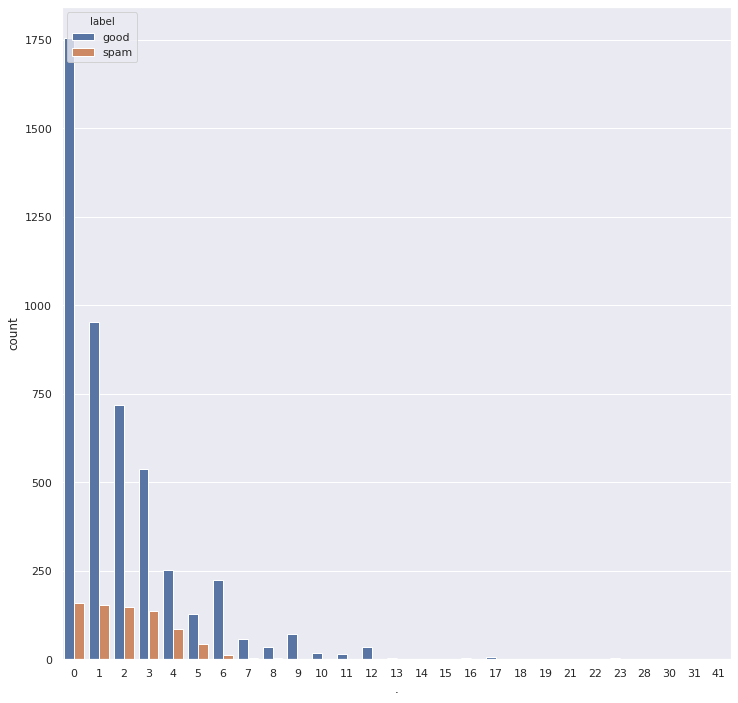

In [ ]:
f, axes = plt.subplots(1, 1, figsize = (12, 12))
sb.countplot(x = ".", hue = "label", data = smsData)

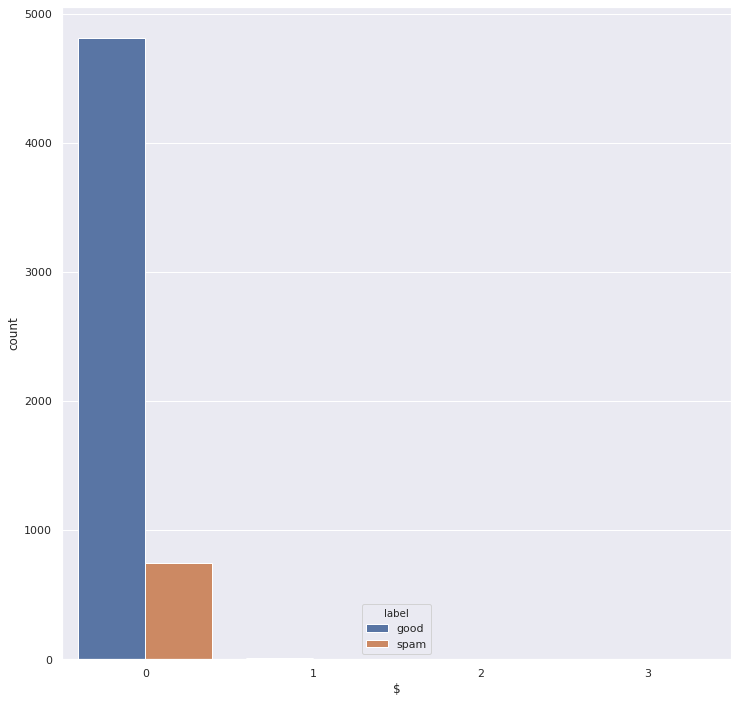

In [ ]:
f, axes = plt.subplots(1, 1, figsize = (12, 12))
sb.countplot(x = "$", hue = "label", data = smsData)

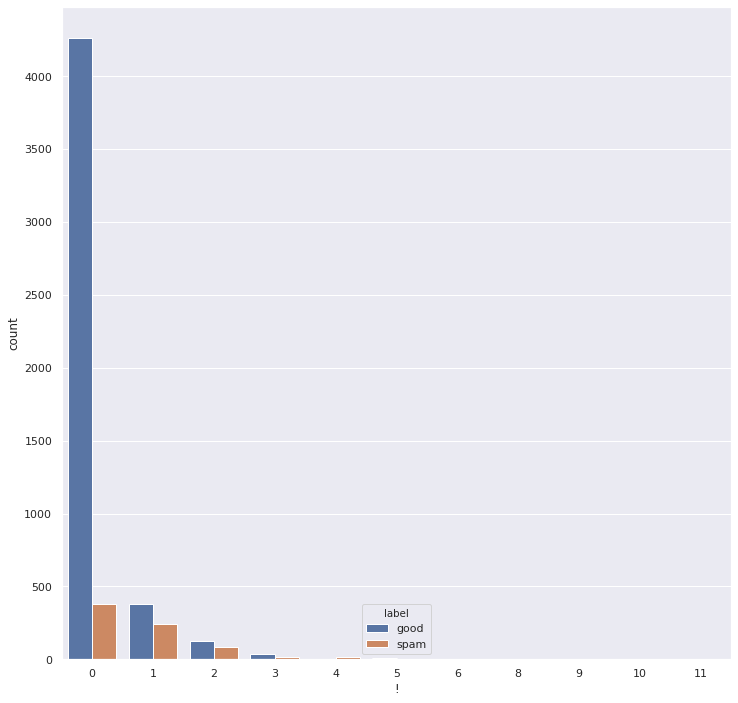

In [ ]:
f, axes = plt.subplots(1, 1, figsize = (12, 12))
sb.countplot(x = "!", hue = "label", data = smsData)

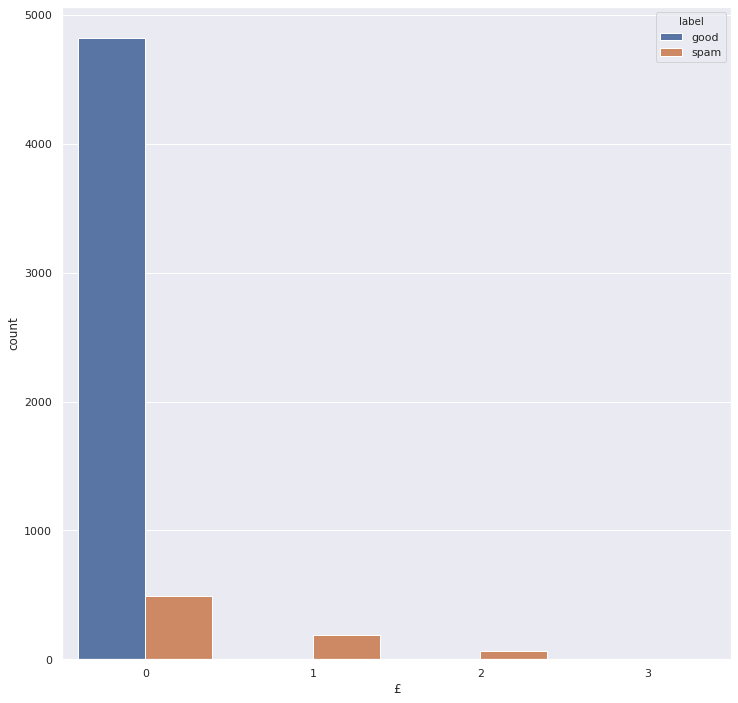

In [ ]:
f, axes = plt.subplots(1, 1, figsize = (12, 12))
sb.countplot(x = "£", hue = "label", data = smsData)

##Seems like this won't be as useful as the previous features, but will still help in some cases
Note that our original good:spam ratio is roughly 6:1. Most of the '0' columns in our previous plot follow the same ratio, so we cannot say anything about text that do not have the special character in it

However, while some have the same distribution in almost all the other columns (like "." and "!"), some has a significantly different distribution in the other columns (like the "1" column of the special character "£")

For that reason, we will keep these features

In [ ]:
#Join the newly found features with the original dataset
count_df = pd.concat([smsData, count_mat.reindex(index=smsData.index)], sort = False, axis = 1)
tfidf_df = pd.concat([smsData, tfidf_mat.reindex(index=smsData.index)], sort = False, axis = 1)
#Let's also remove the "text" column. We don't need it anymore since we already have our features
count_df = count_df.drop(columns= ["text", "Special Characters"])
tfidf_df = tfidf_df.drop(columns = ["text", "Special Characters"])


#Now let's fit our model into the dataset

In [ ]:

#Build the models
tree = DecisionTreeClassifier(max_depth = 100)
forest = RandomForestClassifier(max_depth = 100)

In [ ]:
#Let's build a class to save some time
class Classifiers:
  def __init__(self, classifier, dataset, name):
    self.classifier = classifier
    self.dataset = dataset

    self.X = pd.DataFrame(self.dataset.drop(columns= "label"))
    self.y = self.dataset["label"]
    self.name = name
  
  def plot(self):
    #This function will fit the model, plot the confusion matrix, and print all the accuracy parameters
    X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, train_size = 0.8, random_state = 1000)

    self.classifier.fit(X_train, y_train)

    y_train_pred = self.classifier.predict(X_train)
    y_test_pred = self.classifier.predict(X_test)
    #Plot the confusion matrix
    f, axes = plt.subplots(1, 2, figsize = (18, 6))
    train_cfm = confusion_matrix(y_train, y_train_pred)
    test_cfm = confusion_matrix(y_test, y_test_pred)
    sb.heatmap(data = train_cfm, annot = True, annot_kws = {"size" : 18}, fmt = ".0f", ax = axes[0])
    sb.heatmap(data = test_cfm, annot = True, annot_kws = {"size" : 18}, fmt = ".0f", ax = axes[1])
    
    tn, fp, fn, tp = train_cfm.ravel()
    print("Goodness of Fit of Model \tTrain Dataset for {}".format(self.name))
    print("Classification Accuracy \t:", self.classifier.score(X_train, y_train))
    print("True Negative Rate \t:", tn / (tn + fp))
    print("True Positive Rate \t:", tp / (tp + fn))
    print("False Negative Rate \t:", fn / (tp + fn))
    print("False Positive Rate \t:", fp / (fp + tn))
    print("\n"*3)


    tn, fp, fn, tp = test_cfm.ravel()
    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset for {}".format(self.name))
    print("Classification Accuracy \t:", self.classifier.score(X_test, y_test))
    print("True Negative Rate \t:", tn / (tn + fp))
    print("True Positive Rate \t:", tp / (tp + fn))
    print("False Negative Rate \t:", fn / (tp + fn))
    print("False Positive Rate \t:", fp / (fp + tn))
    print()

  def check_accuracy(self, loop_count):
  #This function randomly splits the dataset loop_count number of times and return the mean of all the accuracy parameters
    acc_mean, tpr_mean, fpr_mean, tnr_mean, fnr_mean = 0, 0, 0, 0, 0
    for i in range(loop_count):
      X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, train_size = 0.8)

      self.classifier.fit(X_train, y_train)

      y_train_pred = self.classifier.predict(X_train)
      y_test_pred = self.classifier.predict(X_test)
      
      acc_mean = ((acc_mean* i) + self.classifier.score(X_test, y_test))/(i + 1)

      test_cfm = confusion_matrix(y_test, y_test_pred)
      tn, fp, fn, tp = test_cfm.ravel()

      tpr = tp / (tp + fn)
      fpr = fp / (fp + tn)
      tnr = tn / (tn + fp)
      fnr = fn / (fn + tp)
      #Calculate the mean
      tpr_mean = ((tpr_mean * i) + tpr)/(i + 1)
      fpr_mean = ((fpr_mean * i) + fpr)/(i + 1)
      tnr_mean = ((tnr_mean * i) + tnr)/(i + 1)
      fnr_mean = ((fnr_mean * i) + fnr)/(i + 1)
    #Print the parameters
    print('Goodness of fit of model: \t {}'.format(self.name))
    print('Mean accuracy: \t\t\t {}'.format(acc_mean))
    print('Mean True Positive Rate \t {}'.format(tpr_mean))
    print('Mean False Positive Rate \t {}'.format(fpr_mean))
    print('Mean True Negative Rate \t {}'.format(tnr_mean))
    print('Mean False Negative Rate \t {}'.format(fnr_mean))
    print('\n'*3)
    #Because, to choose which model is the best to use, we should care about how it performs in the test data

count_tree = Classifiers(tree, count_df, "Count Vectorizer, Decision Tree")
count_forest = Classifiers(forest, count_df, "Count Vectorizer, Random Forest")
tfidf_tree = Classifiers(tree, tfidf_df, "TF-IDF Vectorizer, Decision Tree")
tfidf_forest = Classifiers(forest, tfidf_df, "TF-IDF Vectorizer, Random Forest")



Goodness of Fit of Model 	Train Dataset for Count Vectorizer, Decision Tree
Classification Accuracy 	: 1.0
True Negative Rate 	: 1.0
True Positive Rate 	: 1.0
False Negative Rate 	: 0.0
False Positive Rate 	: 0.0




Goodness of Fit of Model 	Test Dataset for Count Vectorizer, Decision Tree
Classification Accuracy 	: 0.9811659192825112
True Negative Rate 	: 0.9898167006109979
True Positive Rate 	: 0.9172932330827067
False Negative Rate 	: 0.08270676691729323
False Positive Rate 	: 0.010183299389002037



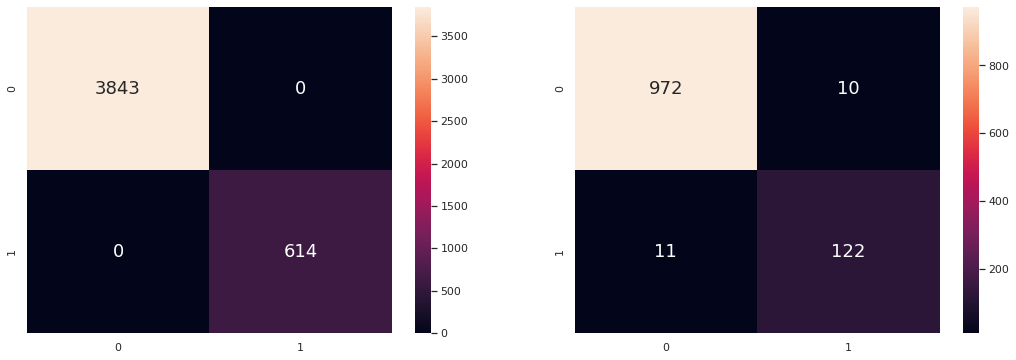

In [ ]:
count_tree.plot()

Goodness of Fit of Model 	Train Dataset for Count Vectorizer, Random Forest
Classification Accuracy 	: 1.0
True Negative Rate 	: 1.0
True Positive Rate 	: 1.0
False Negative Rate 	: 0.0
False Positive Rate 	: 0.0




Goodness of Fit of Model 	Test Dataset for Count Vectorizer, Random Forest
Classification Accuracy 	: 0.9901345291479821
True Negative Rate 	: 1.0
True Positive Rate 	: 0.9172932330827067
False Negative Rate 	: 0.08270676691729323
False Positive Rate 	: 0.0



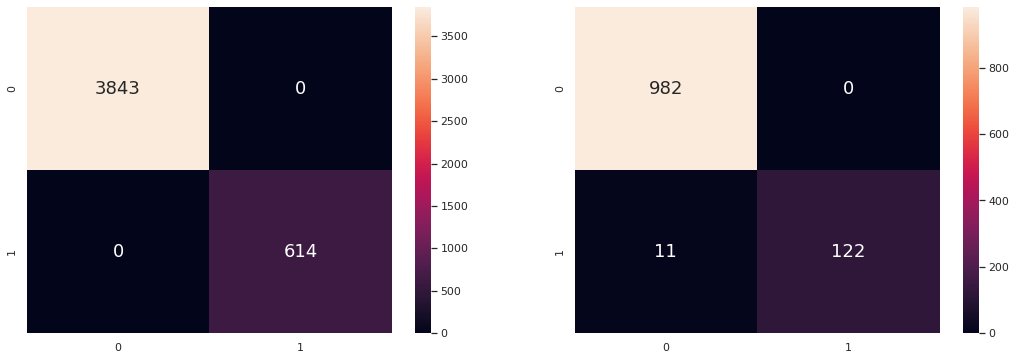

In [ ]:
count_forest.plot()

Goodness of Fit of Model 	Train Dataset for TF-IDF Vectorizer, Decision Tree
Classification Accuracy 	: 1.0
True Negative Rate 	: 1.0
True Positive Rate 	: 1.0
False Negative Rate 	: 0.0
False Positive Rate 	: 0.0




Goodness of Fit of Model 	Test Dataset for TF-IDF Vectorizer, Decision Tree
Classification Accuracy 	: 0.9802690582959641
True Negative Rate 	: 0.9918533604887984
True Positive Rate 	: 0.8947368421052632
False Negative Rate 	: 0.10526315789473684
False Positive Rate 	: 0.008146639511201629



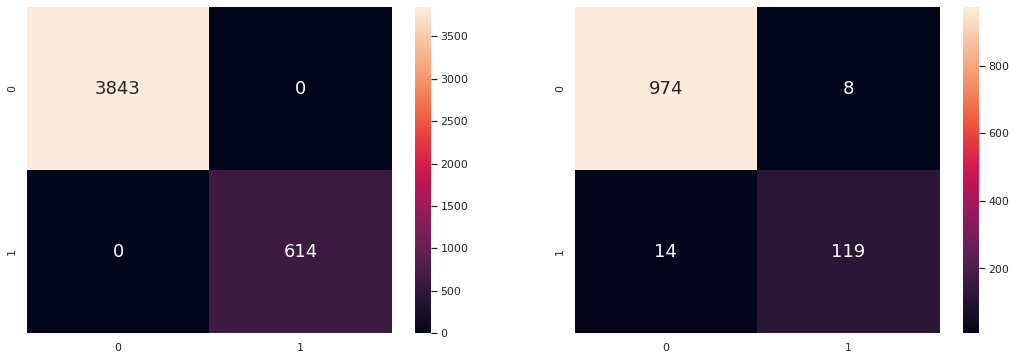

In [ ]:
tfidf_tree.plot()

Goodness of Fit of Model 	Train Dataset for TF-IDF Vectorizer, Random Forest
Classification Accuracy 	: 1.0
True Negative Rate 	: 1.0
True Positive Rate 	: 1.0
False Negative Rate 	: 0.0
False Positive Rate 	: 0.0




Goodness of Fit of Model 	Test Dataset for TF-IDF Vectorizer, Random Forest
Classification Accuracy 	: 0.989237668161435
True Negative Rate 	: 1.0
True Positive Rate 	: 0.9097744360902256
False Negative Rate 	: 0.09022556390977443
False Positive Rate 	: 0.0



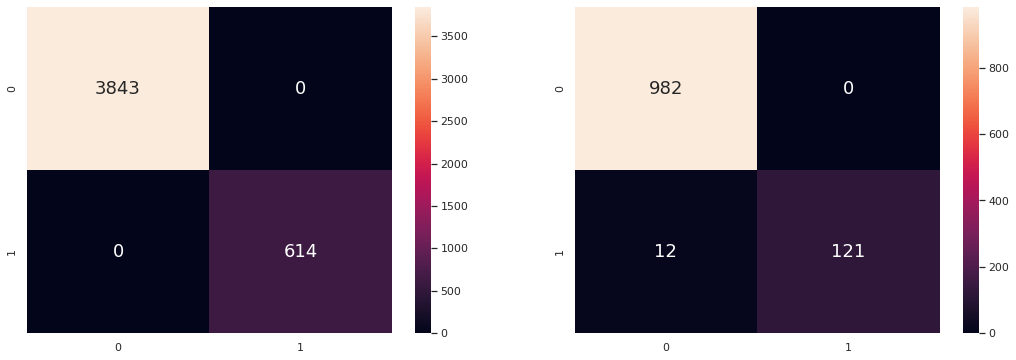

In [ ]:
tfidf_forest.plot()

In [ ]:
loops = 100
#Due to the size of our dataset, too many loops might lead to much longer waiting time
#You may edit this value if the notebook is taking too long to respond

count_tree.check_accuracy(loops)
count_forest.check_accuracy(loops)
tfidf_tree.check_accuracy(loops)
tfidf_forest.check_accuracy(loops)

Goodness of fit of model: 	 Count Vectorizer, Decision Tree
Mean accuracy: 			 0.9821614349775791
Mean True Positive Rate 	 0.9222983608999173
Mean False Positive Rate 	 0.008474362285081794
Mean True Negative Rate 	 0.9915256377149184
Mean False Negative Rate 	 0.07770163910008328




Goodness of fit of model: 	 Count Vectorizer, Random Forest
Mean accuracy: 			 0.989336322869955
Mean True Positive Rate 	 0.9284573629790568
Mean False Positive Rate 	 0.0013136632245064222
Mean True Negative Rate 	 0.9986863367754935
Mean False Negative Rate 	 0.07154263702094331




Goodness of fit of model: 	 TF-IDF Vectorizer, Decision Tree
Mean accuracy: 			 0.9804484304932736
Mean True Positive Rate 	 0.9241491786630529
Mean False Positive Rate 	 0.010804551576622237
Mean True Negative Rate 	 0.9891954484233773
Mean False Negative Rate 	 0.07585082133694707




Goodness of fit of model: 	 TF-IDF Vectorizer, Random Forest
Mean accuracy: 			 0.9885739910313902
Mean True Positive Rate 	 0.92346986348

#Conclusion
- Between the vectorizers, seems like both the **count vectorizer** and the **tf-idf vectorizer** returns similar results.
- However, between the classification models ,the **Random forest classifier** seems to give a much better result, with a significantly better *False positive rate* comparing to the **decision tree classifier**

#References

1. Bird, S., Klein, E., & Loper, E. (2009). Natural language processing with Python: analyzing text with the natural language toolkit. " O'Reilly Media, Inc.". Available at http://www.nltk.org/book/
2.   Pedregosa et al. (2011). "6.2 Feature extraction", Available at
https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

